# mVEP Behavioral Analysis

This notebook contains the analysis codes for mVEP BCI behavioral data.

Scripts are primarily written by Joshua Kosnoff. I've tried to give proper credit to 3rd party sites where due. 

## Load in the behavioral data outputs

The BCI behavioral data are saved in the BCI Outcomes csv file. We can load in the file with the Pandas package. Note that this csv file is publically available on FigShare along with the rest of the data from this study

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

my_df = pd.read_csv("/Users/jkosnoff/Desktop/BCI Outcomes.csv")
my_df.head()

,Subj,Condition,Prediction,Scans,Sonications,Order
0,Subj01,Non-Modulated,6HYNBI6DSB5MONZ,2,0,1
1,Subj01,tFUS-GC,CARNEAOE_MELLIN,2,2,2
2,Subj02,tFUS-GC,CALNBGKERME_LQO,3,4,1
3,Subj02,Decoupled-Sham,SARNEMI26YELLON,3,4,2
4,Subj02,Non-Modulated,C4QN8GCE5PBKLNR,3,0,3


In [2]:
# Get study statistics

print("Total N: ", len(np.unique(my_df.Subj)))
print("tFUS-GC N: ", len(np.unique(my_df["Subj"].loc[my_df.Condition == "tFUS-GC"])))
print("tFUS-CP N: ", len(np.unique(my_df["Subj"].loc[my_df.Condition == "tFUS-GP"])))
print("Non-Modulated N: ", len(np.unique(my_df["Subj"].loc[my_df.Condition == "Non-Modulated"])))
print("Decoupled-Sham N: ", len(np.unique(my_df["Subj"].loc[my_df.Condition == "Decoupled-Sham"])))

Total N:  25
tFUS-GC N:  25
tFUS-CP N:  16
Non-Modulated N:  25
Decoupled-Sham N:  19


## Calculate euclidean error 

In [3]:
import numpy as np
import json 

# Load the mVEP Configs json
with open(fr"/Users/jkosnoff/Library/CloudStorage/Box-Box/mVEP_BCI_cfgs.json") as f:
    mVEP_cfgs = json.load(f)

def calc_euclidean_error(arr1, arr2, grid = np.array(mVEP_cfgs["keyboard"])):
    """
    The Euclidean error is the Euclidean distance on the virtual keyboard between the intended letter
    and the BCI's predicted letter, normalized to a percentage with the maximum keyboard's distance (6*sqrt(2)) 
    and averaged for the number of letters considered
    
    Inputs:
        arr1: the array of the first letter set
        arr2: the array of the second letter set
        grid: the 2D array corresponding to the virtual keyboard
        
    Note that this calculation goes array index-by-index, so the inputs should be of equal length.
    
    Returns:
        err: the Euclidean error
    
    """
    if len(arr1) != len(arr2):
        print(f"Warning! Inputs are of unequal length {arr1} {arr2}. Truncating . . .")
        arr1 = arr1[:min(len(arr1), len(arr2))]
        arr2 = arr2[:min(len(arr1), len(arr2))]
    
    # Initialize error to 0
    err = 0
    for i, j in zip(arr1, arr2):
        if i != j:

            err += np.sqrt((int(np.where(grid == i)[0]) - int(np.where(grid == j)[0]))**(2) +
                           (int(np.where(grid == i)[1]) - int(np.where(grid == j)[1]))**(2))
    
    # Normalize error w.r.t. keyboard
    err /= (grid.shape[0] **(2) + grid.shape[1]**(2))**(0.5) 
    
    # Normalize error w.r.t string length
    err /= len(arr1) 
    
    # Multiply by 100 to convert to a percentage
    err *= 100
    
    return err


def return_target(subject_id, prediction):
    """
    Some subjects had slightly different target strings then others. This returns the proper target string
    for each subject
    """

    if subject_id in ["Subj07","Subj04"]:
        target = "CARNEGIE4MELLON"
    elif len(prediction) == 14:
        target = "CARNEGIEMELLON"
    else:
        target = "CARNEGIE_MELLON"
        
    return target


In [4]:
# Get the target

my_df["target"] = my_df.apply(lambda x: return_target(x['Subj'], x['Prediction']), axis = 1)

In [5]:
import copy
expanded_df = pd.DataFrame(columns = ["Subj", "Condition", "Prediction", "Scans", "Sonications", "target", "Order"])
for i in range(len(my_df)):
    targ = my_df["target"].iloc[i]
    for l in range(len(targ)):
        expanded_df.loc[len(expanded_df)] = {"Subj": my_df["Subj"].iloc[i], 
                                            "Condition": my_df["Condition"].iloc[i],
                                            "Prediction":my_df["Prediction"].iloc[i][l],
                                            "target": my_df["target"].iloc[i][l], 
                                            "Sonications": my_df["Sonications"].iloc[i], 
                                            "Scans": my_df["Scans"].iloc[i],
                                            "Order": my_df["Order"].iloc[i]
                                            }

        
encoder_dict = {key: value for value, key in enumerate(np.unique(expanded_df.Subj))}

expanded_df["EE"] = expanded_df.apply(lambda x: calc_euclidean_error(x['Prediction'], x['target']), axis = 1)

In [6]:
from Outlier_Tests import IQR_Outlier_test

subj_avg_clean_df = pd.DataFrame(columns = ["Subj", "Condition", "EE", "Scans", "Order", "Sonications"])

for subject in np.unique(expanded_df.Subj):
    for condition in np.unique(expanded_df["Condition"].loc[expanded_df.Subj == subject]):
        scans = expanded_df["Scans"].loc[(expanded_df.Condition == condition) & (expanded_df.Subj == subject)].values[0]
        order = expanded_df["Order"].loc[(expanded_df.Condition == condition) & (expanded_df.Subj == subject)].values[0]
        sonications = expanded_df["Sonications"].loc[(expanded_df.Condition == condition) & (expanded_df.Subj == subject)].values[0]
        
        
        ee = expanded_df["EE"].loc[(expanded_df.Condition == condition) & (expanded_df.Subj == subject)].values
        len1 = len(ee)
                
        # Remove Outliers
        ee = ee[~np.array(IQR_Outlier_test(ee))]
        
        len2 = len(ee) 
        # print(f"{subject, condition} Removed {len1 - len2} outliers")
        
        for i in range(len2):
            subj_avg_clean_df.loc[len(subj_avg_clean_df)] = {"Subj": subject, "Condition": condition, 
                                                             "EE": ee[i], 
                                                             "Scans": scans,
                                                             "Order": order,
                                                             "Sonications": sonications}

In [7]:
# Save the euclidean errors to a csv to use in R
# Note that these values are present under Source Data Figure 1

subj_avg_clean_df.to_csv(r"/Users/jkosnoff/Downloads/Removed_Outliers_IQR.csv")

[[(1, 2), 0.0011865432], [(2, 3), 0.0277102836], [(2, 4), 0.0008433473]]
Comparison between Non-Modulated and tFUS-GC: 0.00119
Comparison between tFUS-GC and Decoupled-Sham: 0.02771
Comparison between tFUS-GC and tFUS-GP: 0.00084


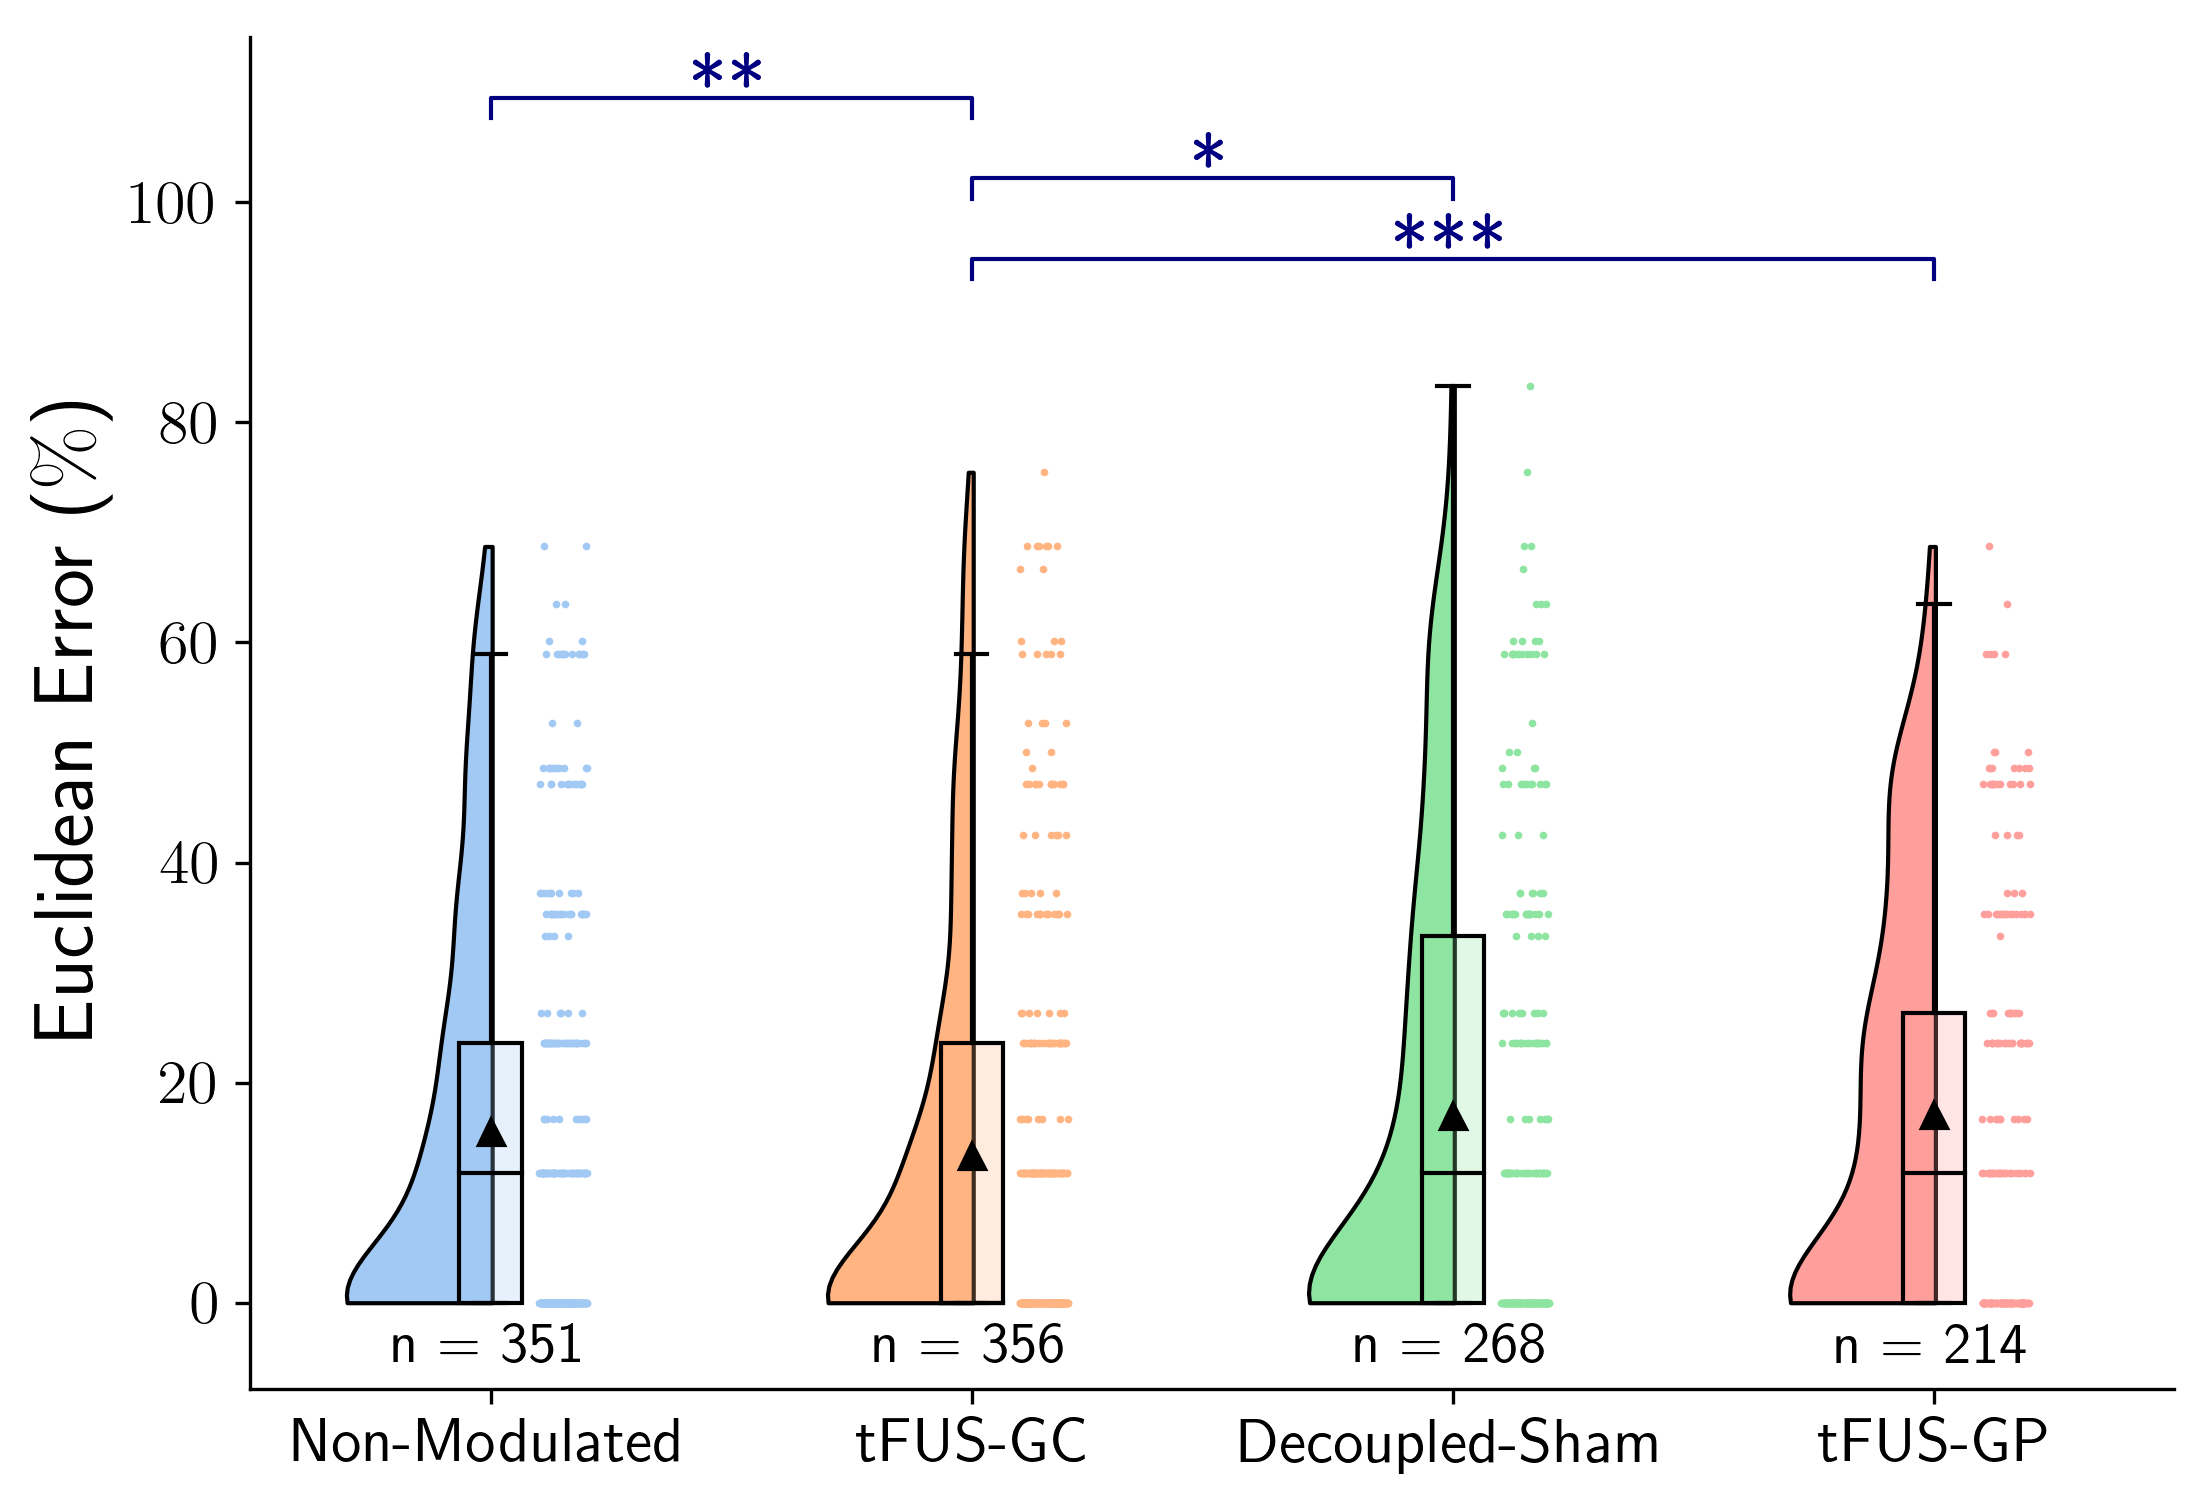

In [10]:
# Create the Plot
from Raincloud_Plot_Maker import statistical_box_and_whisker

subj_avg_dict = {}
for cond in np.unique(subj_avg_clean_df.Condition):
    subj_avg_dict[cond] = subj_avg_clean_df["EE"].loc[subj_avg_clean_df.Condition == cond].values

data = []
keys = ["Non-Modulated", "tFUS-GC", "Decoupled-Sham", "tFUS-GP"]

for key in keys:
    data.append(subj_avg_dict[key])

# Significant p values calculate in R w/ mixed effect modeling
ps = [[(1, 2), 0.0011865432],
       [(2, 3), 0.0277102836],
       [(2, 4), 0.0008433473]]
    
title = "" #r'Single Trial Euclidean Error, Normalized wrt $\sqrt{Scan Epochs}$ * Sonications'
statistical_box_and_whisker(data, keys,
                            plot_type='raincloud',
                            title = title, 
                            y_label=r'Euclidean Error ($\%$)', 
                            print_ps = True, 
                            font = 'Arial',
                            show_means=True, 
                            significant_combinations=ps,
                            sig_color = 'navy',
                            save_fig = "Fig1a.svg",
                            dpi = 300.0)

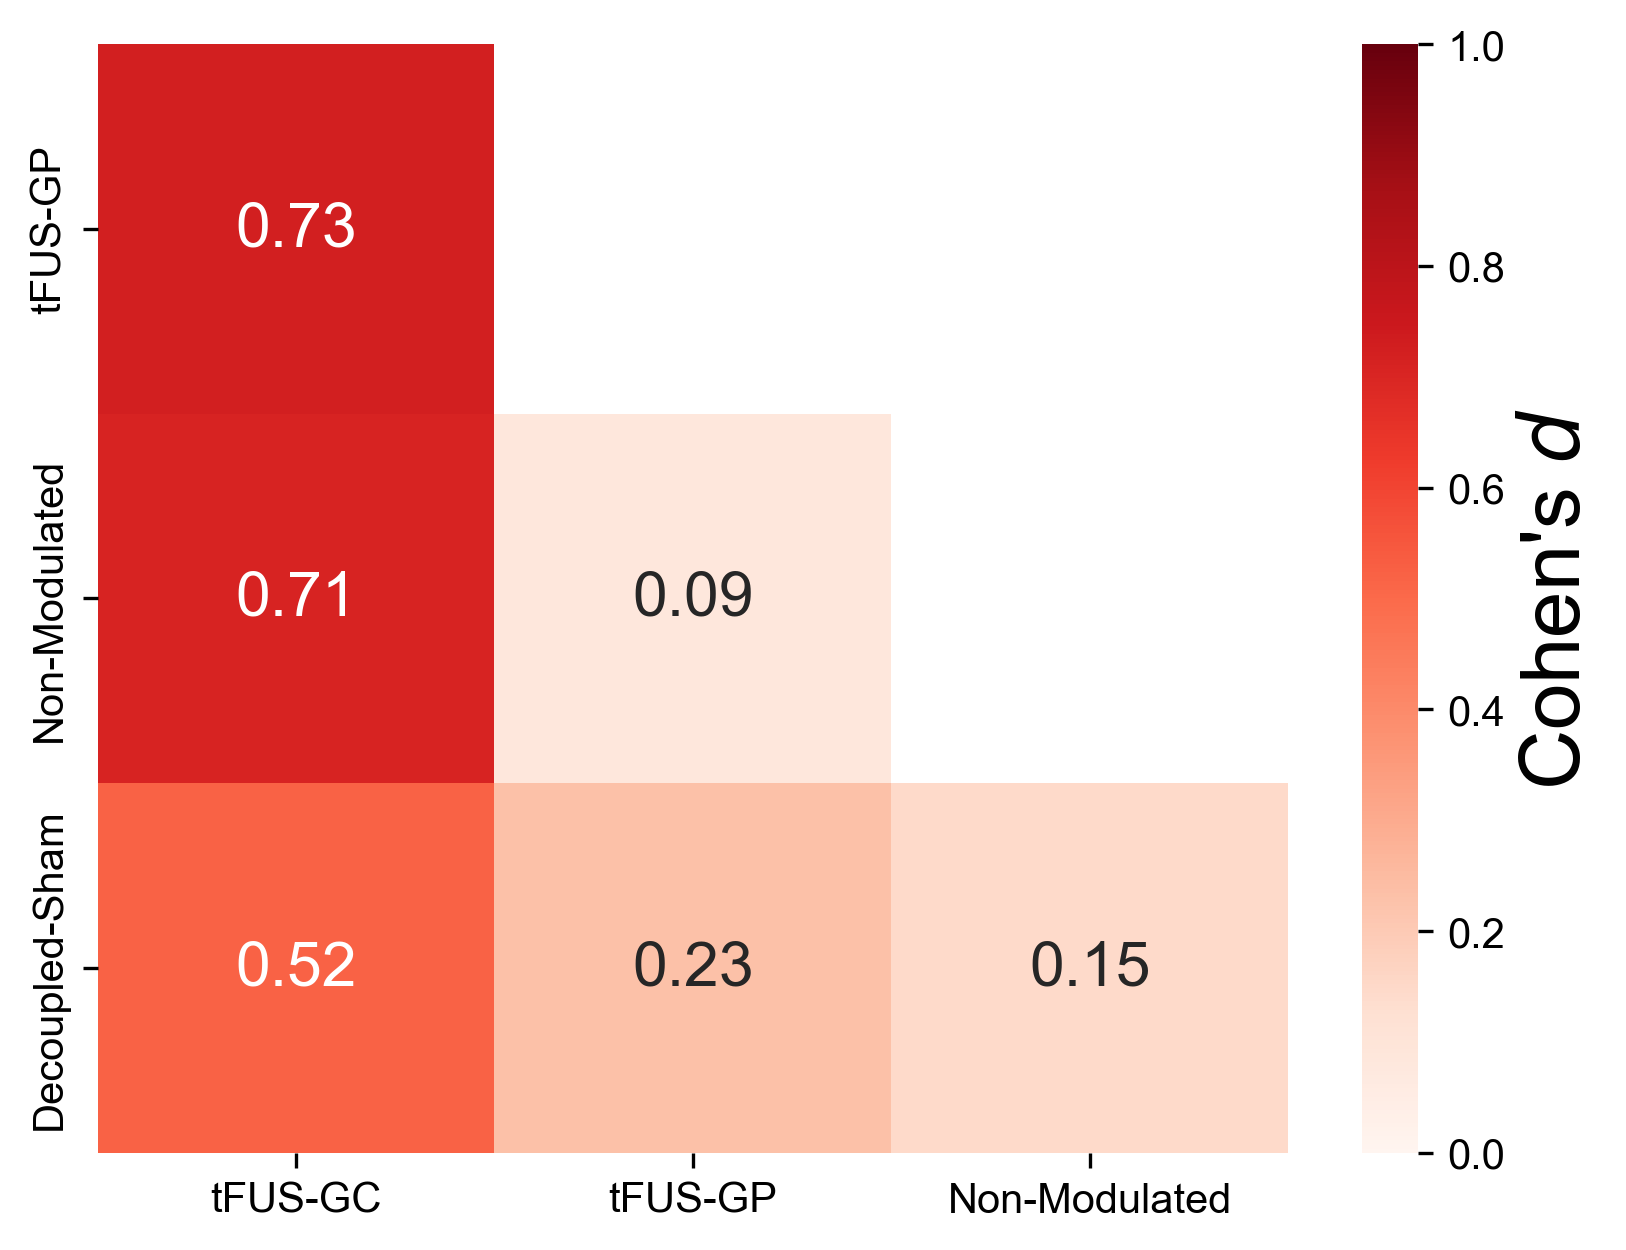

In [12]:
import seaborn as sns

# Cohen's d plotting
# estimates and sem were copied and pasted from the linear mixed effect result in R


# The heatmap will have the following order:
#                 tFUS-GC, tFUS-GP, Non-Modulated, Decoupled-Sham
# tFUS-GC -------------
# tFUS-GP,      
# Non-Modulated
# Decoupled-Sham

plt.rc('figure', dpi=300)
plt.rc('font', family='Arial', size=5)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize 

names = ["tFUS-GC", "tFUS-GP", "Non-Modulated", "Decoupled-Sham"]

estimate = np.array([[5.4860, np.nan, np.nan], 
                     [4.7822, 0.7038, np.nan], 
                     [3.6419, 1.8441, 1.1403]])
sem = np.array([[1.5104, np.nan, np.nan],
                [1.3497, 1.6447, np.nan], 
                [1.3990, 1.5744, 1.5653]])

std = sem * np.sqrt(25)
cohen_d = estimate / std

plt.figure()
ax = sns.heatmap(cohen_d, cmap = 'Reds', fmt = '.2f', vmin = 0, vmax = 1.0, annot = True, 
                 cbar_kws={'label': "Cohen's $d$"}, annot_kws={"size": 15})

ax.figure.axes[-1].yaxis.label.set_size(20)    

ax.set_xticks([i + 0.5 for i in range(len(names) - 1)])
ax.set_xticklabels([i for i in names[:-1]])
ax.set_yticks([i + 0.5 for i in range(len(names) - 1)])
ax.set_yticklabels([i for i in names[1:]]) 
plt.savefig("Fig1b.svg", format = 'svg', dpi = 300)
plt.show()

In [8]:
# Get all the versions of the used software for this analysis

import session_info
session_info.show()